In [1]:
## Basic Python Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

#import math
import os
import pathlib

## Stuff to do with reading files
from tifffile import imread
import tifffile

## Stuff to do with image segmentation
from skimage import measure, util
from skimage.measure import label, regionprops, regionprops_table
from skimage.morphology import remove_small_holes, remove_small_objects, erosion, disk, closing, dilation
from skimage.feature import peak_local_max

from skimage.transform import rescale
import napari
from skimage.filters import threshold_otsu, gaussian
from skimage.segmentation import expand_labels, clear_border, watershed
from skimage.measure import label, regionprops, regionprops_table
from scipy import ndimage as ndi

#from typing import Tuple, List
import trackpy as tp

## Imports for running tasks in parallel
from tqdm import tqdm
import joblib
from joblib import Parallel, delayed
import contextlib




In [2]:
def convert(img, target_type_min, target_type_max, target_type):
    """
    Converts an image to a specified data type while scaling its intensity values.

    This function rescales the intensity values of an image from its original range 
    to a new target range specified by `target_type_min` and `target_type_max`, and 
    then converts it to the desired data type.

    This step is required as deconvolved images are not always scaled 0->255! 

    Parameters:
    -----------
    img : numpy.ndarray
        The input image array to be converted.
    target_type_min : int or float
        The minimum value of the target intensity range.
    target_type_max : int or float
        The maximum value of the target intensity range.
    target_type : numpy.dtype
        The desired data type of the output image (e.g., np.uint8, np.float32).

    Returns:
    --------
    new_img : numpy.ndarray
        The rescaled image with values mapped to the new intensity range and converted 
        to the specified data type.

    Notes:
    ------
    - This function performs a linear transformation to scale pixel values.
    - It ensures that the output values are properly mapped between `target_type_min` and 
      `target_type_max`.
    """
    imin = img.min()
    imax = img.max()

    a = (target_type_max - target_type_min) / (imax - imin)
    b = target_type_max - a * imax
    new_img = (a * img + b).astype(target_type)
    return new_img

In [3]:
image_paths = list(pathlib.Path(".").rglob("*.{}".format("tif")))
test = imread(image_paths[0])
red_channel = convert(test[:,1,:,:], 0,255, np.uint8)
green_channel = convert(test[:,3,:,:], 0, 255, np.uint8)
combined_nuclear_channel = convert((red_channel + green_channel), 0, 255, np.uint8)

Identify and label all nuclei

In [4]:
stacked_nuclei = []
for t in range(combined_nuclear_channel.shape[0]):
    combined_nuclear_thresh = threshold_otsu(combined_nuclear_channel[t,:,:])
    combined_nuclei = combined_nuclear_channel[t,:,:] > combined_nuclear_thresh
    combined_nuclei = closing(combined_nuclei, disk(2))
    combined_nuclei = remove_small_objects(combined_nuclei, min_size=100)
#####################SEPARATE TOUCHING NUCLEI####################
    distances = ndi.distance_transform_edt(erosion(combined_nuclei, disk(2)))
    coordinates = peak_local_max(distances, min_distance = 10) ####seed points at least 4um apart
    marker_locations = coordinates.data
    markers = np.zeros(combined_nuclei.shape, dtype=np.uint32)
    marker_indices = tuple(np.round(marker_locations).astype(int).T)
    markers[marker_indices] = np.arange(len(marker_locations)) + 1
    markers_big = dilation(markers, disk(2))
    segmented_nuclei = watershed(-distances, markers_big, mask=combined_nuclei)
    segmented_nuclei = clear_border(segmented_nuclei)
    nuclear_labels = label(segmented_nuclei)
    stacked_nuclei.append(nuclear_labels)
all_combined_nuclei = np.stack(stacked_nuclei, axis=0)


Idenfify red nuclei, green nuclei, and yellow nuclei (nuclei that are red and green)

In [5]:
for i, nuclear_channel in enumerate([red_channel, green_channel]):
    stacked_nuclei = []
    for t in range(red_channel.shape[0]):
        nuclear_thresh = threshold_otsu(nuclear_channel[t,:,:])
        nuclei = nuclear_channel[t,:,:] > nuclear_thresh
        nuclei = closing(nuclei, disk(2))
        nuclei = remove_small_objects(nuclei, min_size=100)
        stacked_nuclei.append(nuclei)
    #####################SEPARATE TOUCHING NUCLEI####################
    if i == 0:
        all_red_nuclei = np.stack(stacked_nuclei, axis=0)
    else:
        all_green_nuclei = np.stack(stacked_nuclei, axis=0)
all_yellow_nuclei = ((all_red_nuclei > 0) & (all_green_nuclei > 0)).astype(np.uint8)

In [6]:
# Link nuclei first
nuclei_data = []
for t in range(all_combined_nuclei.shape[0]):
    labels_t = all_combined_nuclei[t]
    props = regionprops(labels_t)
    
    for prop in props:
        y, x = prop.centroid
        nuclei_data.append({'frame': t, 'x': x, 'y': y})

nuclei_df = pd.DataFrame(nuclei_data)
linked_df = tp.link_df(nuclei_df, search_range=20, memory=2) # can update based on your best guess -> can use napari to validate
linked_df.shape

Frame 82: 107 trajectories present.


(6172, 4)

In [7]:

# Filter long-lived tracks
particle_frame_counts = linked_df.groupby('particle')['frame'].nunique()
min_required_frames = all_red_nuclei.shape[0] * 0.2 #currently required to be visible in >20% frames
long_lived_particles = particle_frame_counts[particle_frame_counts > min_required_frames].index
long_tracks = linked_df[linked_df['particle'].isin(long_lived_particles)].copy()
long_tracks.shape

(1846, 4)

In [8]:

# Round for indexing
long_tracks['x_rounded'] = long_tracks['x'].round().astype(int)
long_tracks['y_rounded'] = long_tracks['y'].round().astype(int)

# Initialize color percentage columns
long_tracks['%red'] = np.nan
long_tracks['%green'] = np.nan
long_tracks['%yellow'] = np.nan

# Compute %red, %green, %yellow only for nuclei in long_tracks
for idx, row in long_tracks.iterrows():
    t = int(row['frame'])
    x = int(row['x_rounded'])
    y = int(row['y_rounded'])

    if 0 <= y < all_combined_nuclei.shape[1] and 0 <= x < all_combined_nuclei.shape[2]:
        label_id = all_combined_nuclei[t, y, x]
        if label_id == 0:
            continue

        nucleus_mask = all_combined_nuclei[t] == label_id
        total_area = nucleus_mask.sum()
        if total_area == 0:
            continue

        red_mask = all_red_nuclei[t]
        green_mask = all_green_nuclei[t]
        yellow_mask = (red_mask > 0) & (green_mask > 0)

        red_area = (nucleus_mask & red_mask).sum()
        green_area = (nucleus_mask & green_mask).sum()
        yellow_area = (nucleus_mask & yellow_mask).sum()

        red_unique = red_area - yellow_area
        green_unique = green_area - yellow_area

        long_tracks.at[idx, '%red'] = 100 * red_unique / total_area
        long_tracks.at[idx, '%green'] = 100 * green_unique / total_area
        long_tracks.at[idx, '%yellow'] = 100 * yellow_area / total_area

# Classify dominant color
def classify_color(row):
    if row['%yellow'] > 15:
        return 'yellow'
    elif row['%red'] > row['%green']:
        return 'red'
    else:
        return 'green'

long_tracks['color'] = long_tracks.apply(classify_color, axis=1)

Plot trajectories

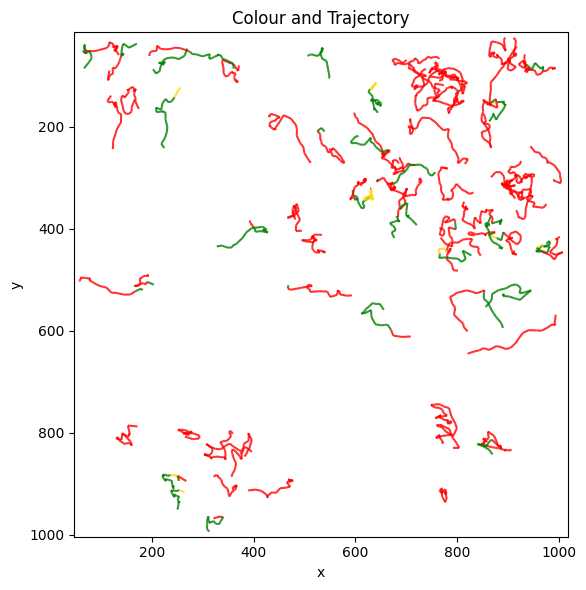

In [9]:
color_map = {"red": "red",
    "green": "green",
    "yellow": "gold",
    "none": "gray"}

fig, ax = plt.subplots(figsize=(8, 6))

all_x = []
all_y = []

for particle_id, track in long_tracks.groupby("particle"):
    track = track.sort_values("frame")
    coords = track[["x", "y"]].to_numpy()
    all_x.extend(track["x"].values)
    all_y.extend(track["y"].values)


    segments = np.stack([coords[:-1], coords[1:]], axis=1)
    segment_colors = [color_map.get(c, "gray") for c in track["color"].iloc[:-1]]
    lc = LineCollection(segments, colors=segment_colors, linewidths=1.5, alpha=0.8)
    ax.add_collection(lc)

    ax.set_xlim(min(all_x) - 10, max(all_x) + 10)
    ax.set_ylim(min(all_y) - 10, max(all_y) + 10)
    ax.invert_yaxis()  

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Colour and Trajectory")
ax.set_aspect("equal")
plt.tight_layout()
plt.show()
